In this section we use frequency domain methods proposed by Amin et al (2023) to produce a deepfake detector (classification method). Later we use these methods to build a bolt-on generative adversarial network (GAN) which reduces the effectiveness of such detection methods.

In [1]:
import csv
import cv2
import gc
import math
import numpy as np
import pandas as pd
import os
import random
import scipy
import seaborn as sns
import sklearn
import sklearn.decomposition
import sklearn.manifold
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.svm
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
import warnings

from matplotlib import pyplot as plt
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Our dataset is the Celeb-DF data set which is comprised of deep fake videos. We will first attempt deepfake detection on deepfake images for a frame based detection method, then expand our methods to video segments. The purpose of this is to verify the statistical properties demonstrated in Amin et al (2023) on 2-dimensional data before we analyze 3-dimensional data (time & space).

To this end, we take our video dataset, and break it up into an image dataset.

In [3]:
real_path = 'Celeb-DF/Celeb-real'
fake_path = 'Celeb-DF/Celeb-synthesis'
imag_path = 'Celeb-DF/Images'
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
seed = 752
batch_size = 256
os.chdir('/content/drive/MyDrive')
combo_spectral_data = pd.read_csv('combo_spectral_data_frame&video_ids.csv')

In [23]:
def vid2im(video_path, imag_path, rf):
    print('Video/input path:', video_path)
    print('Image/output path:', imag_path)
    print('Data type:', rf)
    t_start = time.time()
    video_list = os.listdir(video_path)
    frame_num = 0
    z_pad = math.ceil(math.log10(len(video_list)*15*30))
    for video_name in tqdm(video_list):
        video_name = os.path.join(video_path, video_name)
        video = cv2.VideoCapture(video_name)
        while True:
            flag, frame = video.read()
            if not flag:
                break
            frame_num += 1
            frame_name = '.'.join([rf,str(frame_num).zfill(z_pad), 'jpg'])
            frame_name = os.path.join(imag_path, frame_name)
            cv2.imwrite(frame_name, frame)
        video.release()
    t_end = time.time()
    t_delta = t_end - t_start
    print(f'Video-set to image-set conversion completed in {t_delta//60} minutes {math.floor(t_delta%60)} seconds')

class IMG_gen:
    def __init__(self, img_path):
        self.path_gen = os.scandir(img_path)
        self.state = 0
        self.path = None
        self.img = None
        self.label = None
        self.label_dict = {'f':1, 'r':0}

    @staticmethod
    def get_img_color(path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

    def __next__(self):
        self.path = next(self.path_gen)
        self.label = self.label_dict[os.path.basename(self.path)[0]]
        self.state += 1
        self.img = self.get_img_color(self.path)
        return self.img, self.label

class FACE_gen(IMG_gen):
    def __init__(self, img_path):
        super().__init__(img_path)
        self.facial = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml').detectMultiScale

    def get_face_box(self, img):
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        try:
            x,y,w,h = self.facial(img_gray, minSize=(10, 10))[0]
            return x, y, x+w, y+h
        except:
            return None

    def __next__(self):
        self.path = next(self.path_gen)
        self.label = self.label_dict[os.path.basename(self.path)[0]]
        self.state += 1
        self.img = self.get_img_color(self.path)
        self.xyxy = self.get_face_box(self.img)
        try:
            self.face = self.img[self.xyxy[1]:self.xyxy[3],
                                 self.xyxy[0]:self.xyxy[2],
                                 :]
        except:
            self.face = None
        return (self.face, self.label)

class BKGD_gen(FACE_gen):
    def __init__(self, img_path):
        super().__init__(img_path)
        self.bkdg = None

    @staticmethod
    def get_bkgd_box(shape, x1, y1, x2, y2):
        def overlap_check(x, y):
            return not(x+w<x1 or
                       x>x2 or
                       y+h<y1 or
                       y>y2)
        w, h = x2-x1, y2-y1
        x_max, y_max = shape[1], shape[0]
        #We use up to 1k guesses for a background box
        for i in range(1000):
            x, y = random.randint(0, x_max-1-w), random.randint(0, y_max-1-h)
            if not overlap_check(x, y):
                break
            if i==1000-1 and overlap_check(x,y):
                print('Failed to retrieve a background in 1000 attempts')
                return None
        return x, y, x+w, y+w

    def __next__(self):
        self.path = next(self.path_gen)
        self.label = self.label_dict[os.path.basename(self.path)[0]]
        self.state += 1
        self.img = self.get_img_color(self.path)
        self.xyxy = self.get_face_box(self.img)
        try:
            self.face = self.img[self.xyxy[1]:self.xyxy[3],
                                 self.xyxy[0]:self.xyxy[2],
                                 :]
        except:
            self.face = None
        self.bkgd_xyxy = self.get_bkgd_box(self.img.shape, *self.xyxy)
        try:
            self.bkgd = self.img[self.bkgd_xyxy[1]:self.bkgd_xyxy[3],
                                 self.bkgd_xyxy[0]:self.bkgd_xyxy[2],
                                 :]
        except:
            self.bkgd = None
        return (self.bkgd, self.label)

def spec_stats(img):
    '''Returns the feature vector for the image:
            cor_rb, cor_rb, cor_gb, m_rgb, mu_rgb, M_rgb
        in complex spectrum then amplitude spectrum'''
    def get_stats(chan1, chan2, chan3):
        mean_stats = []
        spec_stats = []
        spec_stats.append([np.corrcoef(chan1, chan2).real[0,1],
                           np.corrcoef(chan1, chan3).real[0,1],
                           np.corrcoef(chan2, chan3).real[0,1]])
        mean_stats.append([np.mean(np.abs(chan1 - chan2)).real,
                           np.mean(np.abs(chan1 - chan3)).real,
                           np.mean(np.abs(chan2 - chan3)).real])
        spec_stats.append([np.min(mean_stats),
                           np.mean(mean_stats),
                           np.max(mean_stats)])
        return spec_stats
    img = img.astype('float32')
    img -= img.mean(axis=(0,1))
    img_fft = np.fft.fft2(img, axes=(0,1), norm='forward')
    red_fft = img_fft[:,:,0].flatten()
    green_fft = img_fft[:,:,1].flatten()
    blue_fft = img_fft[:,:,2].flatten()
    spec_stats = []
    spec_stats.append(get_stats(red_fft, green_fft, blue_fft))
    spec_stats.append(get_stats(np.abs(red_fft), np.abs(green_fft), np.abs(blue_fft)))
    return np.array(spec_stats).flatten().astype('float32')

def spec_feat_extr(img_gen):
    t_0 = time.time()
    col_names = ['cor_rg', 'cor_rb', 'cor_gb',
                 'm_rgb', 'mu_rgb', 'M_rgb',
                 'cor_|rg|', 'cor_|rb|', 'cor_|gb|',
                 'm_|rgb|', 'mu_|rgb|', 'M_|rgb|',
                 'label']
    data = []
    i = 0
    t_start = time.time()
    while True:
        i+=1
        if i%1000 ==0:
            t_end = time.time()
            dt = t_end-t_start
            print(f'{dt//60} min {math.floor(dt%60)} per 1000 images, {i//1000}k images complete')
            t_start = time.time()
        try:
            x, y = next(img_gen)
        except TypeError:
            continue
        except:
            break
        if isinstance(x, type(None)):
            continue
        data.append(np.concatenate((spec_stats(x),np.array([y]))))
    data_frame = pd.DataFrame(data, columns=col_names)
    dt = time.time() - t_0
    hr = dt//3600
    mn = dt//60 - 60*hr
    sc = math.floor(dt%60)
    print(f'Total run time {hr} hours {mn} minutes {sc} seconds')
    return data_frame

def visualize_samples(samples, labels, title="Samples visualization", colors=["b", "r"]):
    """ Visualize first three dimensions of samples. """
    # Convert colors to NumPy array
    colors = np.array(colors)
    # Create figure
    fig = plt.figure(figsize=(20, 5))

    # Plot first two dimensions on a 2D plot
    ax_2d = fig.add_subplot(1, 2, 1)
    ax_2d.set_title(f"{title} [2D]")
    ax_2d.scatter(samples[:, 0], samples[:, 1], c=colors[labels], s=10)

    # Plot first three dimensions on a 3D plot
    ax_3d = fig.add_subplot(1, 2, 2, projection="3d")
    ax_3d.set_title(f"{title} [3D]")
    ax_3d.scatter(samples[:, 0], samples[:, 1], samples[:, 2], c=colors[labels],s=10)
    print(fig)

class VAE(nn.Module):
    def __init__(self, schedule=(12,9,7,5,3), device=device):
        #Instanciates the VAE as a pytorch module for autograd
        super(VAE, self).__init__()
        #Forms the encoder/decoder layers as a list following a schedule
        def ED_layers(schedule):
            layers = []
            for ind in range(len(schedule)-2):
                i_put, o_put = schedule[ind], schedule[ind+1]
                #Linear layers due to the non-shift invarient datatype
                layers.extend([nn.Linear(i_put, o_put),
                #Batch norm to prevent exploding gradients and neuron weights
                              nn.BatchNorm1d(o_put),
                              nn.ReLU(),
                #Dropout to improve generalization
                              nn.Dropout()])
            i_put, o_put = schedule[-2], schedule[-1]
            #Terminal linear layer before use encoder-latent or decoder-reconstruction
            layers.append(nn.Linear(i_put, o_put))
            return layers
        self.encoder = nn.Sequential(*ED_layers(schedule))
        self.decoder = nn.Sequential(*ED_layers(schedule[::-1]))
        self.min_val_loss = float('inf')
        self.device = device
        self.encoder.to(self.device)
        self.decoder.to(self.device)
        print(self)

    def forward(self, x):
        x = x.to(device)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def latent(self, x):
        x = x.to(self.device)
        self.eval()
        with torch.no_grad():
            x_latent = self.encoder(x)
        return x_latent.detach().to('cpu')

    def VAE_train(self, train_loader, valid_loader, n_epochs=100, loss=nn.MSELoss(), optimizer=optim.Adam, model_path='VAE_model'):
        optimizer = optimizer(self.parameters(), lr=.0005, betas=(.5,.999))
        epoch_bar = tqdm(range(n_epochs),desc='Epoch', initial=1)
        self.training_loss, self.validation_loss = [], []

        print('VAE training started:')
        for epoch in epoch_bar:
            loss_train = loss_valid = 0
            batch_size = set_size = 0
            #training
            self.train(True)
            for data in train_loader:
                #training
                x = y = data[0].to(self.device)
                optimizer.zero_grad()
                x = self(x)
                loss_0 = loss(x,y)
                loss_0.backward()
                optimizer.step()
                #statistics
                batch_size = x.shape[0]
                set_size += batch_size
                loss_train += loss_0.item()*batch_size
            loss_train /= set_size

            batch_size = set_size = 0
            #evaluation
            self.eval()
            with torch.no_grad():
                for data in valid_loader:
                    #evaluation
                    x = y = data[0].to(self.device)
                    x = self(x)
                    loss_1 = loss(x,y)
                    #statistics
                    batch_size = x.shape[0]
                    set_size += batch_size
                    loss_valid += loss_1.item()*batch_size
            loss_valid /= set_size

            if loss_valid < self.min_val_loss:
                self.min_val_loss = loss_valid
                model_path+'_epoch_{}'.format(epoch)
                torch.save(self.state_dict(), model_path)

            epoch_bar.set_postfix({'training loss':loss_train,
                                   'validation loss':loss_valid,
                                   'best validation loss':self.min_val_loss})
            self.training_loss.append(loss_train)
            self.validation_loss.append(loss_valid)
        print(f'VAE training {n_epochs} epochs complete.')

def hist12(df_list, df_key = ('real', 'fake'), colors = ('b', 'r')):
    assert len(df_list) == len(df_key) == len(colors)
    col_list = list(df_list[0].columns)
    fig, ax = plt.subplots(2,3, figsize=(12, 8))
    for ind in range(6):
        col = col_list[ind]
        #ax[ind//3, ind%3].set_xlim(left=.75)
        for df, df_k, c in zip(df_list, df_key, colors):
            sns.histplot(df[col],
                         color=c,
                         kde=True,
                         stat="density",
                         ax=ax[ind//3, ind%3],
                         label = f'{col}: {df_k}')
    fig.suptitle('FSSF complex spectrum histograms')
    plt.tight_layout()
    plt.show()
    fig, ax = plt.subplots(2,3, figsize=(12, 8))
    for ind in range(6,12):
        col = col_list[ind]
        #ax[(ind-6)//3, (ind-6)%3].set_xlim(left=.75)
        for df, df_k, c in zip(df_list, df_key, colors):
            sns.histplot(df[col],
                         color=c,
                         kde=True,
                         stat="density",
                         ax=ax[(ind-6)//3, (ind-6)%3],
                         label = f'{col}: {df_k}')
    fig.suptitle('FSSF magnitude spectrum histograms')
    plt.tight_layout()
    plt.show()

def print_metrics(y_true, y_pred, y_score, estimator_name=None):
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
    auc = round(sklearn.metrics.roc_auc_score(y_true, y_score) *100,2)

    print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_true, y_pred)*100,2)}%',
          f'Precision: {round(sklearn.metrics.precision_score(y_true, y_pred)*100,2)}%',
          f'Recall: {round(sklearn.metrics.recall_score(y_true, y_pred)*100,2)}%',
          f'F1: {round(sklearn.metrics.f1_score(y_true, y_pred)*100,2)}%',
          f'AUC: {auc}%',
          sep='\n')

    fig, ax = plt.subplots(1,2, figsize=(8, 4))
    fig.suptitle(f'{estimator_name} Confusion Matrix and ROC Curve')
    plt.tight_layout()
    display_confusion_matrix = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix)
    display_confusion_matrix.plot(ax=ax[0])
    display_roc_curve = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name=estimator_name)
    display_roc_curve.plot(ax=ax[1], plot_chance_level=True)
    plt.show()

def dim_red_tests(data_frame, data_type, schedule=(12,9,7,5,3), model_path='VAE_model', subsample=True):
    print(f'Dimensionality reduction tests: {data_type}')
    t_start = t_0 = time.time()
    x, y = data_frame.drop(columns='label'), data_frame['label'].astype('int')
    x_scaled = sklearn.preprocessing.StandardScaler().fit_transform(x)
    print(f'Data scaling: {math.floor(time.time()-t_0)} sec')

    t_0 = time.time()
    x_pca = sklearn.decomposition.PCA(3).fit_transform(x_scaled)
    visualize_samples(x_pca, y)
    print(f'Prinical Component Analysis (PCA): {math.floor(time.time()-t_0)} sec')

    if subsample:
        t_0 = time.time()
        random.seed(752)
        sample = random.sample(range(len(data_frame)), 12000)
        x_sampled, y_sampled = x_scaled[sample,:], y.iloc[sample]
        print(f'Subsampling: {math.floor(time.time()-t_0)} sec')
    else:
        print('Subsampling bipassed')
        x_sampled, y_sampled = x_scaled, y

    t_0 = time.time()
    x_pol = sklearn.decomposition.KernelPCA(kernel='poly').fit_transform(x_sampled)
    visualize_samples(x_pol, y_sampled)
    print(f'Kernel PCA Polynomial: {math.floor(time.time()-t_0)} sec')

    t_0 = time.time()
    x_rbf = sklearn.decomposition.KernelPCA(kernel='rbf').fit_transform(x_sampled)
    visualize_samples(x_rbf, y_sampled)
    print(f'Kernel PCA Radial Basis Function (RBF): {math.floor(time.time()-t_0)} sec')

    t_0 = time.time()
    x_cos = sklearn.decomposition.KernelPCA(kernel='cosine').fit_transform(x_sampled)
    visualize_samples(x_cos, y_sampled)
    print(f'Kernel PCA Cosine: {math.floor(time.time()-t_0)} sec')

    t_0 = time.time()
    x_iso = sklearn.manifold.Isomap(n_components=3).fit_transform(x_sampled)
    visualize_samples(x_iso, y_sampled)
    print(f'Manifold learning Isomap: {math.floor(time.time()-t_0)} sec')

    t_0 = time.time()
    x_spe = sklearn.manifold.SpectralEmbedding(n_components=3).fit_transform(x_sampled)
    visualize_samples(x_spe, y_sampled)
    print(f'Manifold learning Spectral Embedding: {math.floor(time.time()-t_0)} sec')

    t_0 = time.time()
    x_tsn = sklearn.manifold.TSNE(n_components=3).fit_transform(x_sampled)
    visualize_samples(x_tsn, y_sampled)
    print(f'Manifold learning t-distributed Stochastic Neighbor Embedding (t-SNE): {math.floor(time.time()-t_0)} sec')

    t_0 = time.time()
    model_vae = VAE(schedule=schedule)
    x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(x_scaled, y, test_size=.091, random_state=752)
    x_train = torch.tensor(x_train).to(torch.float32)
    x_valid = torch.tensor(x_valid).to(torch.float32)
    train_set = torch.utils.data.TensorDataset(x_train)
    valid_set = torch.utils.data.TensorDataset(x_valid)
    train_loader = torch.utils.data.DataLoader(train_set,batch_size=34000,shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_set,batch_size=3500,shuffle=True)
    model_vae.VAE_train(train_loader, valid_loader, n_epochs=500, model_path=model_path)
    fig, ax = plt.subplots(1,1)
    ax.plot(model_vae.training_loss)
    ax.plot(model_vae.validation_loss)
    ax.set_xlabel('Epochs')
    ax.legend(['Training loss', 'Validation Loss'])
    plt.show()
    x_latent = model_vae.latent(torch.tensor(x_scaled).to(torch.float32)).detach().numpy()
    visualize_samples(x_scaled, y)
    print(f'Variational Autoencoder (VAE): {math.floor(time.time()-t_0)} sec')
    t_end = time.time()
    print(f'Dimensionality reduction tests complete: {(t_end-t_start)//60} min {math.floor((t_end-t_start)%60)}')

class VID_gen:
    def __init__(self, vid_path, label):
        self.path_gen = os.scandir(vid_path)
        self.state = 0
        self.path = None
        self.vid = None
        self.label = label

    def __next__(self):
        self.path = next(self.path_gen)
        video = cv2.VideoCapture(self.path)
        frame_list = []
        while True:
            flag, frame = video.read()
            if not flag:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_list.append(frame)
        video.release()
        self.vid = np.array(frame_list)
        self.state += 1
        return self.vid, self.label
        #self.vid -> frame, height, width, channels

def spec_stats_video(video):
    def get_stats(chan1, chan2, chan3):
        mean_stats = []
        spec_stats = []
        spec_stats.append([np.corrcoef(chan1, chan2).real[0,1],
                           np.corrcoef(chan1, chan3).real[0,1],
                           np.corrcoef(chan2, chan3).real[0,1]])
        mean_stats.append([np.mean(np.abs(chan1 - chan2)).real,
                           np.mean(np.abs(chan1 - chan3)).real,
                           np.mean(np.abs(chan2 - chan3)).real])
        spec_stats.append([np.min(mean_stats),
                           np.mean(mean_stats),
                           np.max(mean_stats)])
        return spec_stats
    video = video.astype('float32')
    video -= video.mean(axis=(0,1,2)).astype('float32')
    video = scipy.fft.fft2(video, axes=(1,2), norm='forward').astype('complex64')
    gc.collect()
    red_fft = video[:,:,:,0].flatten().astype('float32')
    green_fft = video[:,:,:,1].flatten().astype('float32')
    blue_fft = video[:,:,:,2].flatten().astype('float32')
    data = []
    data.append(get_stats(red_fft, green_fft, blue_fft))
    data.append(get_stats(np.abs(red_fft), np.abs(green_fft), np.abs(blue_fft)))
    video = scipy.fft.fft(video, axis=0, norm='forward').astype('complex64')
    red_fft = video[:,:,:,0].flatten().astype('float32')
    green_fft = video[:,:,:,1].flatten().astype('float32')
    blue_fft = video[:,:,:,2].flatten().astype('float32')
    gc.collect()
    data.append(get_stats(red_fft.astype('float32'),
                          green_fft.astype('float32'),
                          blue_fft.astype('float32')))
    data.append(get_stats(np.abs(red_fft).astype('float32'),
                          np.abs(green_fft).astype('float32'),
                          np.abs(blue_fft).astype('float32')))
    return np.array(data).flatten().astype('float32')

def spec_feat_extr_video(vid_gen_list, csv_path, start_point=(0,0)):
    t_start = time.time()
    i = 0
    col_names = ['cor_tf_rg', 'cor_tf_rb', 'cor_tf_gb',
                 'm_tf_rgb', 'mu_tf_rgb', 'M_tf_rgb',
                 'cor_tf_|rg|', 'cor_tf_|rb|', 'cor_tf_|gb|',
                 'm_tf_|rgb|', 'mu_tf_|rgb|', 'M_tf_|rgb|',
                 'cor_ff_rg', 'cor_ff_rb', 'cor_ff_gb',
                 'm_ff_rgb', 'mu_ff_rgb', 'M_ff_rgb',
                 'cor_ff_|rg|', 'cor_ff_|rb|', 'cor_ff_|gb|',
                 'm_ff_|rgb|', 'mu_ff_|rgb|', 'M_ff_|rgb|',
                 'label', 'file_name']
    with open(csv_path, 'a', newline='') as file:
        csv_writer = csv.writer(file)
        for vid_gen_ind in range(start_point[0], len(vid_gen_list)):
            vid_gen = vid_gen_list[vid_gen_ind]
            if start_point[1] != 0:
                #Scans through the os.scan generator without returning an image to rapidly re-index to a new start point
                for _ in range(start_point[1]):
                    vid_gen.state+=1
                    next(vid_gen.path_gen)
            t0 = time.time()
            while True:
                i += 1
                if i%10 == 0:
                    t1 = time.time()
                    dt = t1-t0
                    print(f'{dt//60} min {math.floor(dt%60)} per 10 videos, {i//10} videos complete')
                    t0 = time.time()
                try:
                    x, y = next(vid_gen)
                except StopIteration:
                    break
                except:
                    continue
                gc.collect()
                csv_writer.writerow([*spec_stats_video(x), y, vid_gen.path])
                file.flush()
                os.fsync(file.fileno())
    dt = time.time() - t_start
    hr = dt//3600
    mn = dt//60 - 60*hr
    sc = math.floor(dt%60)
    print(f'Total run time {hr} hours {mn} minutes {sc} seconds')
    data_frame = pd.read_csv(csv_path, names=col_names, index_col='file_name')
    return data_frame

def spec_feat_extr_combo(img_gen, csv_path, start_point=0):
    '''
       img_gen must be a BKGD_gen type object to extract the:
           full image IMG_gen, FACE_gen and BKGD_gen
           face section FACE_gen and BKGD_gen
           background section BKGD_gen
    '''
    t_start = t0 = time.time()
    i = 0
    col_names = ['cor_img_rg', 'cor_img_rb', 'cor_img_gb',
                 'm_img_rgb', 'mu_img_rgb', 'M_img_rgb',
                 'cor_img_|rg|', 'cor_img_|rb|', 'cor_img_|gb|',
                 'm_img_|rgb|', 'mu_img_|rgb|', 'M_img_|rgb|',
                 'cor_face_rg', 'cor_face_rb', 'cor_face_gb',
                 'm_face_rgb', 'mu_face_rgb', 'M_face_rgb',
                 'cor_face_|rg|', 'cor_face_|rb|', 'cor_face_|gb|',
                 'm_face_|rgb|', 'mu_face_|rgb|', 'M_face_|rgb|',
                 'cor_bkgd_rg', 'cor_bkgd_rb', 'cor_bkgd_gb',
                 'm_bkgd_rgb', 'mu_bkgd_rgb', 'M_bkgd_rgb',
                 'cor_bkgd_|rg|', 'cor_bkgd_|rb|', 'cor_bkgd_|gb|',
                 'm_bkgd_|rgb|', 'mu_bkgd_|rgb|', 'M_bkgd_|rgb|',
                 'label', 'file_name']
    with open(csv_path, 'a', newline='') as file:
        csv_writer = csv.writer(file)
        for ind in range(start_point):
            img_gen.state += 1
            next(img_gen.path_gen)
        while True:
            i+=1
            if i%1000 == 0:
                file.flush()
                os.fsync(file.fileno())
                t1 = time.time()
                dt = t1-t0
                print(f'{dt//60} min {math.floor(dt%60)} per 1000 videos, {i//1000}k videos complete - CSV saved')
                t0 = time.time()
            try:
                _,_ = next(img_gen)
                x_img, x_face, x_bkgd = img_gen.img, img_gen.face, img_gen.bkgd
                y_label, file_name = img_gen.label, img_gen.path
            except StopIteration:
                break
            except:
                continue
            if isinstance(x_face, type(None)) or isinstance(x_bkgd, type(None)):
                continue
            csv_writer.writerow([*spec_stats(x_img),
                                 *spec_stats(x_face),
                                 *spec_stats(x_bkgd),
                                 y_label, file_name])
    dt = time.time() - t_start
    hr = dt//3600
    mn = dt//60 - 60*hr
    sc = math.floor(dt%60)
    print(f'Total run time {hr} hours {mn} minutes {sc} seconds')
    data_frame = pd.read_csv(csv_path, names=col_names, index_col='file_name')
    return data_frame

def pre_processing(data_frame, tvt=[.2,.2], seed=752, use_torch=False):
    def to_torch32(datasets):
        for ind, dataset in enumerate(datasets):
            dataset = torch.tensor(np.array(dataset)).to(torch.float32)
            datasets[ind] = dataset
        return datasets
    def reshape_6x6(datasets):
        for ind, dataset in enumerate(datasets):
            dataset = dataset.reshape(len(dataset), 6, -1).transpose(1,2)
            datasets[ind] = dataset
        return datasets
    #Sorts the dataframe by video then by frame within each video
    data_frame.sort_values(by='vid', inplace=True)
    for ind in range(int(data_frame['vid'].values.max())):
        data_frame[data_frame['vid']==ind].sort_values(by='img',inplace=True)
    #z scales the dataframe
    data_frame.iloc[:,:-3] = (data_frame.iloc[:,:-3] - data_frame.iloc[:,:-3].mean())/data_frame.iloc[:,:-3].std()
    #Downsamples the dataframe to balance number of videos
    go_bag = list(set(data_frame[data_frame['label']==0]['vid']))
    grab_bag = list(set(data_frame[data_frame['label']==1]['vid']))
    equal_count = len(go_bag)
    if not isinstance(seed,type(None)):
        random.seed(seed)
    sample = random.sample(grab_bag, equal_count)
    go_bag.extend(sample)
    data_frame = data_frame[data_frame['vid'].isin(go_bag)]
    #Splits the dataframe into training, validation and test set
    test_size = math.floor(len(go_bag)*tvt[1])
    test_sample = random.sample(go_bag,test_size)
    train_sample = list(set(go_bag) - set(test_sample))
    if not use_torch:
        tvt[0]=0
    val_size = math.floor(len(train_sample)*tvt[0])
    val_sample = random.sample(train_sample,val_size)
    train_sample = list(set(train_sample) - set(val_sample))
    data_frame_val = data_frame[data_frame['vid'].isin(val_sample)]
    data_frame_train = data_frame[data_frame['vid'].isin(train_sample)]
    data_frame_test = data_frame[data_frame['vid'].isin(test_sample)]

    x_train, x_val, x_test = np.array(data_frame_train.iloc[:,:-3]), np.array(data_frame_val.iloc[:,:-3]), np.array(data_frame_test.iloc[:,:-3])
    y_train, y_val, y_test = np.array(data_frame_train['label']), np.array(data_frame_val['label']), np.array(data_frame_test['label'])
    if use_torch:
        x_train, x_val, x_test, y_train, y_val, y_test = to_torch32([x_train, x_val, x_test, y_train, y_val, y_test])
        x_train, x_val, x_test = reshape_6x6([x_train, x_val, x_test])
    return x_train, x_val, x_test, y_train, y_val, y_test

def to_dataloader(data_tensors, answer_tensors,batch_size=batch_size):
    dataloaders = []
    for data_tensor, answer_tensor in zip(data_tensors, answer_tensors):
        #Must be a one hot encoding for BCE loss now, BCE loss on a binary coded vector is depricated...
        answer_tensor = torch.nn.functional.one_hot(answer_tensor.type(torch.LongTensor),2)
        #BCE loss is not computable for an integer valued tensor... so we have to conver it back to a float...
        answer_tensor = answer_tensor.to(data_tensor.dtype)
        dataset = torch.utils.data.TensorDataset(data_tensor, answer_tensor)
        dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
        dataloaders.append(dataloader)
    return dataloaders

class FSSF_RESNET(nn.Module):
    def __init__(self, device=device, dil=14, ker=16, opad=8):
        super(FSSF_RESNET, self).__init__()
        weights = ResNet50_Weights.DEFAULT
        self.device = device
        #Our input is a 6x6x1 FSSF array, we must upscale to 224x224x3 for use by the pretrained RESNET
        self.upscale = nn.ConvTranspose2d(1,3,(ker,ker),output_padding=opad,dilation=dil).to(self.device)
        self.resnet = resnet50(weights=weights).to(self.device)
        #This replaces the terminal fully connected layer to allow us to perform 2 binary classification
        self.resnet.fc = nn.Linear(2048, 2).to(self.device)
        self.min_val_loss = float('inf')
        self.training_loss, self.validation_loss = [], []
        print(self)
    def forward(self, x):
        x = x.to(self.device)
        #Required because input is b.h.w need b.c.h.w for c=1
        x = x.unsqueeze(1)
        x = self.upscale(x)
        x = self.resnet(x)
        return x
    def FSSF_RESNET_train(self, train_loader, val_loader, n_epochs=100, loss=nn.BCELoss(), optimizer=optim.Adam, model_path='FSSF_RESNET_model'):
        optimizer = optimizer(self.parameters(), lr=.0005, betas=(.5,.999))
        print('FSSF_RESNET training started:')
        epoch_bar = tqdm(range(n_epochs),desc='Epoch', initial=1)
        for epoch in epoch_bar:
            loss_train = loss_valid = 0
            batch_size = set_size = 0
            #training
            self.train(True)
            for data in train_loader:
                #training
                x, y = data
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                x = self(x)
                x = nn.Sigmoid()(x)
                loss_0 = loss(x,y)
                loss_0.backward()
                optimizer.step()
                #statistics
                batch_size = x.shape[0]
                set_size += batch_size
                loss_train += loss_0.item()*batch_size
            loss_train /= set_size

            batch_size = set_size = 0
            #evaluation
            self.eval()
            with torch.no_grad():
                for data in val_loader:
                    #evaluation
                    x, y = data
                    x, y = x.to(self.device), y.to(self.device)
                    x = self(x)
                    x = nn.Sigmoid()(x)
                    loss_1 = loss(x,y)
                    #statistics
                    batch_size = x.shape[0]
                    set_size += batch_size
                    loss_valid += loss_1.item()*batch_size
            loss_valid /= set_size

            if loss_valid < self.min_val_loss:
                self.min_val_loss = loss_valid
                model_path+'_epoch_{}'.format(epoch)
                torch.save(self.state_dict(), model_path)

            epoch_bar.set_postfix({'training loss':loss_train,
                                   'validation loss':loss_valid,
                                   'best validation loss':self.min_val_loss})
            self.training_loss.append(loss_train)
            self.validation_loss.append(loss_valid)
        print(f'FSSF_RESNET training {n_epochs} epochs complete.')
        fig, ax = plt.subplots(1,1, figsize=(4, 4))
        plt.tight_layout()
        ax.plot(self.training_loss)
        ax.plot(self.validation_loss)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Binary Cross Entropy Loss')
        ax.set_title('FSSF RESNET training curves')
        ax.legend(['Training loss', 'Validation Loss'])
        plt.show()

    def FSSF_RESNET_test(self, test_loader, loss=nn.BCELoss()):
        print('FSSF_RESNET testing started:')
        batch_size = set_size = loss_test = 0
        #evaluation
        self.eval()
        y_true_running, y_pred_running, y_logit_running = [], [], []
        with torch.no_grad():
            for data in test_loader:
                #evaluation
                x, y = data
                x, y = x.to(self.device), y.to(self.device)
                #Creates a running tracker of the true values for use in our print metrics function
                y_true_running.append(y[:,1].detach().cpu().numpy())
                x = self(x)
                #Creates a running tracker for the logits so we can plot them to analyze clusters
                y_logit_running.append(x.detach().cpu().numpy())
                x = nn.Sigmoid()(x)
                #Creates a running tracker of the predicted values for use in our print metrics function
                y_pred_running.append(x[:,1].detach().cpu().numpy())
                loss_1 = loss(x,y)
                #statistics
                batch_size = x.shape[0]
                set_size += batch_size
                loss_test += loss_1.item()*batch_size
        loss_test /= set_size
        y_true = np.concatenate(y_true_running)
        y_score = np.concatenate(y_pred_running)
        y_logit = np.concatenate(y_logit_running)
        y_pred = np.floor(y_score+.5)

        print(f'Testing Loss: {loss_test}')
        fig, ax = plt.subplots(1,2, figsize=(4, 8))
        colors = np.array(["b", "r"])
        plt.tight_layout()
        ax[0].scatter(y_logit[:,0], y_logit[:,1], c=colors[y_true.astype(int)], s=10)
        ax[0].set_title('FSSF RESNET testset output logits')
        ax[0].legend(['Real', 'Fake'])
        y_logit_1d = sklearn.decomposition.PCA(1).fit_transform(y_logit)
        sns.histplot(y_logit_1d[y_true.astype(int)==1], color="r", kde=True, stat="density", ax=ax[1], label='Fake logits')
        sns.histplot(y_logit_1d[y_true.astype(int)==0], color="b", kde=True, stat="density", ax=ax[1],label='Real logits')
        plt.show()
        print_metrics(y_true, y_pred, y_score, estimator_name='FSSF RESNET Classifier')
        print(f'FSSF_RESNET testing complete.')
        return y_logit

def pre_processing_temporal(data_frame, tvt=[.2,.2], seed=752, use_resnet=True):
    def to_torch32(datasets):
        for ind, dataset in enumerate(datasets):
            dataset = torch.tensor(np.array(dataset)).to(torch.float32)
            datasets[ind] = dataset
        return datasets
    def reshape_6x6(datasets):
        for ind, dataset in enumerate(datasets):
            dataset = dataset.reshape(len(dataset), 6, -1).transpose(1,2)
            datasets[ind] = dataset
        return datasets
    def reshape_data(data_frame, use_resnet=True):
        #Assumes input is a segment of the original dataframe selected by video
        #Assumes that the input dataframe segment is sorted temporally
        #Reshaped to a 36x224x1  pseudo-image for use in a modified RESNET
        #Reshaped to a 36x512x1  pseudo-token for use in a modified BERT
        if data_frame.empty:
            return
        t_max = 224 if use_resnet else 512
        x = np.zeros((36,t_max))
        data_array = np.array(data_frame).T[:-3,:]
        t_len = min(t_max, len(data_frame))
        x[:,:t_len] = data_array[:,:t_len]
        y = int(data_frame['label'].iloc[0])
        return x, y
    def collect_samples(data_frame, samples, use_resnet):
        x, y = [], []
        for sample in samples:
            x0, y0 = reshape_data(data_frame[data_frame['vid']==sample],use_resnet)
            x.append(x0)
            y.append(y0)
        return np.array(x), np.array(y)
    #Sorts the dataframe by video then by frame within each video
    data_frame.sort_values(by='vid', inplace=True)
    for ind in range(int(data_frame['vid'].values.max())):
        data_frame[data_frame['vid']==ind].sort_values(by='img',inplace=True)
    #z scales the dataframe
    data_frame.iloc[:,:-3] = (data_frame.iloc[:,:-3] - data_frame.iloc[:,:-3].mean())/data_frame.iloc[:,:-3].std()
    #Downsamples the dataframe to balance number of videos
    go_bag = list(set(data_frame[data_frame['label']==0]['vid']))
    grab_bag = list(set(data_frame[data_frame['label']==1]['vid']))
    equal_count = len(go_bag)
    if not isinstance(seed,type(None)):
        random.seed(seed)
    sample = random.sample(grab_bag, equal_count)
    go_bag.extend(sample)
    data_frame = data_frame[data_frame['vid'].isin(go_bag)]
    #Splits the dataframe into training, validation and test set
    test_size = math.floor(len(go_bag)*tvt[1])
    test_sample = random.sample(go_bag,test_size)
    train_sample = list(set(go_bag) - set(test_sample))
    val_size = math.floor(len(train_sample)*tvt[0])
    val_sample = random.sample(train_sample,val_size)
    train_sample = list(set(train_sample) - set(val_sample))
    x_train, y_train = collect_samples(data_frame, train_sample, use_resnet)
    x_val, y_val = collect_samples(data_frame, val_sample, use_resnet)
    x_test, y_test = collect_samples(data_frame, test_sample, use_resnet)
    x_train, x_val, x_test, y_train, y_val, y_test = to_torch32([x_train, x_val, x_test, y_train, y_val, y_test])
    return x_train, x_val, x_test, y_train, y_val, y_test

class FSSF_RESNET_temporal(FSSF_RESNET):
    def __init__(self, device=device, dil=13, ker=15, opad=6):
        super(FSSF_RESNET_temporal, self).__init__()
        #Our input is a 36x224x1 FSSF array, we must upscale to 224x224x3 for use by the pretrained RESNET
        self.upscale = nn.ConvTranspose2d(1,3,(ker,1),output_padding=(opad,0),dilation=(dil,1)).to(device)
        print(self)

class MLP(nn.Module):
    def __init__(self, schedule=(36,33,30,27,24,21,18,15,12,9,6,3,2), device=device):
        #Instanciates the MLP as a pytorch module for autograd
        super(MLP, self).__init__()
        #Forms the encoder/decoder layers as a list following a schedule
        def ED_layers(schedule):
            layers = []
            for ind in range(len(schedule)-2):
                i_put, o_put = schedule[ind], schedule[ind+1]
                #Linear layers due to the non-shift invarient datatype
                layers.extend([nn.Linear(i_put, o_put),
                #Batch norm to prevent exploding gradients and neuron weights
                              nn.BatchNorm1d(o_put),
                              nn.ReLU(),
                #Dropout to improve generalization
                              nn.Dropout()])
            i_put, o_put = schedule[-2], schedule[-1]
            #Terminal linear layer before use encoder-latent or decoder-reconstruction
            layers.append(nn.Linear(i_put, o_put))
            return layers
        self.mlp = nn.Sequential(*ED_layers(schedule))
        self.min_val_loss = float('inf')
        self.device = device
        self.mlp.to(self.device)
        self.training_loss, self.validation_loss = [], []
        print(self)

    def forward(self, x):
        x = x.to(device)
        x = x.reshape(-1,36)
        x = self.mlp(x)
        return x

    def MLP_train(self, train_loader, valid_loader, n_epochs=100, loss=nn.BCELoss(), optimizer=optim.Adam, model_path='VAE_model'):
        optimizer = optimizer(self.parameters(), lr=.0005, betas=(.5,.999))
        epoch_bar = tqdm(range(n_epochs),desc='Epoch', initial=1)

        print('VAE training started:')
        for epoch in epoch_bar:
            loss_train = loss_valid = 0
            batch_size = set_size = 0
            #training
            self.train(True)
            for data in train_loader:
                #training
                x, y = data
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                x = self(x)
                x = nn.Sigmoid()(x)
                loss_0 = loss(x,y)
                loss_0.backward()
                optimizer.step()
                #statistics
                batch_size = x.shape[0]
                set_size += batch_size
                loss_train += loss_0.item()*batch_size
            loss_train /= set_size

            batch_size = set_size = 0
            #evaluation
            self.eval()
            with torch.no_grad():
                for data in valid_loader:
                    #evaluation
                    x, y = data
                    x, y = x.to(self.device), y.to(self.device)
                    x = self(x)
                    x = nn.Sigmoid()(x)
                    loss_1 = loss(x,y)
                    #statistics
                    batch_size = x.shape[0]
                    set_size += batch_size
                    loss_valid += loss_1.item()*batch_size
            loss_valid /= set_size

            if loss_valid < self.min_val_loss:
                self.min_val_loss = loss_valid
                model_path+'_epoch_{}'.format(epoch)
                torch.save(self.state_dict(), model_path)

            epoch_bar.set_postfix({'training loss':loss_train,
                                   'validation loss':loss_valid,
                                   'best validation loss':self.min_val_loss})
            self.training_loss.append(loss_train)
            self.validation_loss.append(loss_valid)
        print(f'MLP training {n_epochs} epochs complete.')
        fig, ax = plt.subplots(1,1, figsize=(4, 4))
        plt.tight_layout()
        ax.plot(self.training_loss)
        ax.plot(self.validation_loss)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Binary Cross Entropy Loss')
        ax.set_title('FSSF RESNET training curves')
        ax.legend(['Training loss', 'Validation Loss'])
        plt.show()
    def MLP_test(self, test_loader, loss=nn.BCELoss()):
            print('MLP testing started:')
            batch_size = set_size = loss_test = 0
            #evaluation
            self.eval()
            y_true_running, y_pred_running, y_logit_running = [], [], []
            with torch.no_grad():
                for data in test_loader:
                    #evaluation
                    x, y = data
                    x, y = x.to(self.device), y.to(self.device)
                    #Creates a running tracker of the true values for use in our print metrics function
                    y_true_running.append(y[:,1].detach().cpu().numpy())
                    x = self(x)
                    #Creates a running tracker for the logits so we can plot them to analyze clusters
                    y_logit_running.append(x.detach().cpu().numpy())
                    x = nn.Sigmoid()(x)
                    #Creates a running tracker of the predicted values for use in our print metrics function
                    y_pred_running.append(x[:,1].detach().cpu().numpy())
                    loss_1 = loss(x,y)
                    #statistics
                    batch_size = x.shape[0]
                    set_size += batch_size
                    loss_test += loss_1.item()*batch_size
            loss_test /= set_size
            y_true = np.concatenate(y_true_running)
            y_score = np.concatenate(y_pred_running)
            y_logit = np.concatenate(y_logit_running)
            y_pred = np.floor(y_score+.5)

            #print(f'Testing Loss: {loss_test}')
            #fig, ax = plt.subplots(1,2, figsize=(4, 8))
            #colors = np.array(["b", "r"])
            #plt.tight_layout()
            #ax[0].scatter(y_logit[:,0], y_logit[:,1], c=colors[y_true.astype(int)], s=10)
            #ax[0].set_title('MLP testset output logits')
            #ax[0].legend(['Real', 'Fake'])
            #y_logit_1d = sklearn.decomposition.PCA(1).fit_transform(y_logit)
            #sns.histplot(y_logit_1d[y_true.astype(int)==1], color="r", kde=True, stat="density", ax=ax[1], label='Fake logits')
            #sns.histplot(y_logit_1d[y_true.astype(int)==0], color="b", kde=True, stat="density", ax=ax[1],label='Real logits')
            #plt.show()
            print_metrics(y_true, y_pred, y_score, estimator_name='MLP Classifier')
            print(f'MLP testing complete.')
            #return y_logit

In [5]:
os.chdir('/content/drive/MyDrive')
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
#torch.autograd.set_detect_anomaly(True)
#torch.backends.cudnn.benchmark = False
#torch.backends.cudnn.deterministic = True

In [6]:
#combo_spectral_data = spec_feat_extr_combo(combo_gen, 'combo_spectral_statistics_running.csv', start_point=0)
#combo_spectral_data.dropna(inplace=True)
#combo_spectral_data.to_csv('combo_spectral_statistics.csv',index=False)
combo_spectral_data = pd.read_csv('combo_spectral_data_frame&video_ids.csv')
combo_spectral_data.describe()

,cor_img_rg,cor_img_rb,cor_img_gb,m_img_rgb,mu_img_rgb,M_img_rgb,cor_img_|rg|,cor_img_|rb|,cor_img_|gb|,m_img_|rgb|,...,M_bkgd_rgb,cor_bkgd_|rg|,cor_bkgd_|rb|,cor_bkgd_|gb|,m_bkgd_|rgb|,mu_bkgd_|rgb|,M_bkgd_|rgb|,label,img,vid
count,353513.000000,353513.000000,353513.000000,353513.000000,353513.000000,353513.000000,353513.000000,353513.000000,353513.000000,353513.000000,...,353513.000000,353513.000000,353513.000000,353513.000000,353513.000000,353513.000000,353513.000000,353513.000000,353513.000000,353513.000000
mean,0.874043,0.747145,0.919217,0.002207,0.003143,0.003981,0.945543,0.903537,0.965019,0.001415,...,0.017247,0.954228,0.928717,0.959729,0.005674,0.009056,0.011880,0.837047,137845.783366,493.783739
std,0.153848,0.254058,0.158077,0.000882,0.001360,0.001865,0.054346,0.074634,0.058438,0.000566,...,0.018862,0.069539,0.083726,0.072436,0.005409,0.009463,0.013249,0.369323,95938.180646,281.577626
min,0.062688,-0.431877,-0.108375,0.000718,0.000792,0.000873,0.664818,0.617504,0.602274,0.000431,...,0.000000,0.001760,-0.206638,-0.206638,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.862719,0.672935,0.930257,0.001618,0.002224,0.002662,0.934826,0.865917,0.967726,0.001017,...,0.006836,0.947032,0.905222,0.960693,0.002731,0.003829,0.004609,1.000000,47304.000000,234.000000
50%,0.927844,0.856468,0.967144,0.002088,0.002937,0.003745,0.965569,0.926615,0.983978,0.001319,...,0.012094,0.981670,0.959724,0.986501,0.004385,0.006558,0.008333,1.000000,128395.000000,516.000000
75%,0.963030,0.911706,0.983671,0.002448,0.003708,0.004749,0.980733,0.958193,0.991378,0.001636,...,0.020955,0.993946,0.986015,0.995605,0.006825,0.011086,0.014522,1.000000,223343.000000,743.000000
max,0.993999,0.991381,0.998651,0.006595,0.012432,0.017197,0.997789,0.995649,0.999338,0.004369,...,0.670180,1.000000,1.000000,1.000000,0.201101,0.325683,0.466046,1.000000,312876.000000,952.000000


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


FSSF_RESNET(
  (upscale): ConvTranspose2d(1, 3, kernel_size=(16, 16), stride=(1, 1), dilation=(14, 14), output_padding=(8, 8))
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, a

Epoch: 26it [43:04, 103.38s/it, training loss=0.0774, validation loss=9.58, best validation loss=3.57]

FSSF_RESNET training 25 epochs complete.


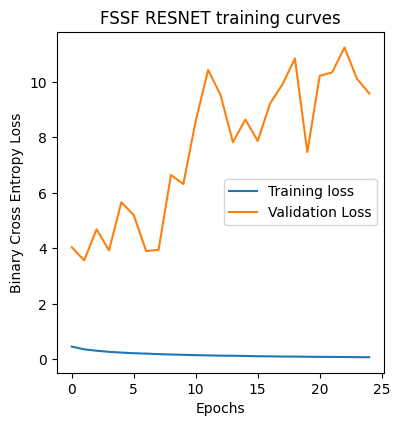

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = pre_processing(combo_spectral_data, use_torch=True)
train_loader, val_loader, test_loader = to_dataloader([x_train, x_val, x_test], [y_train, y_val, y_test])
model_resnet = FSSF_RESNET()
model_resnet.FSSF_RESNET_train(train_loader, val_loader, n_epochs=25,model_path='FSSF_RESNET_model_ker16_dil14_opad8')

FSSF_RESNET(
  (upscale): ConvTranspose2d(1, 3, kernel_size=(16, 16), stride=(1, 1), dilation=(14, 14), output_padding=(8, 8))
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, a

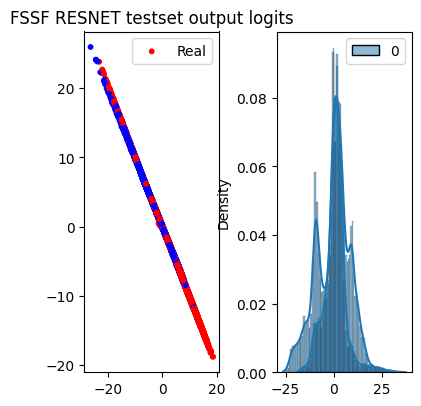

Accuracy: 37.46%
Precision: 40.18%
Recall: 42.08%
F1: 41.11%
AUC: 30.31%


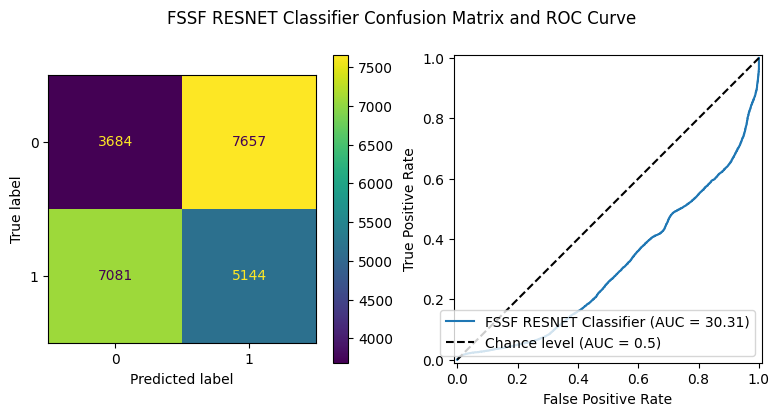

FSSF_RESNET testing complete.


array([[ 0.50999033, -0.54394025],
       [-1.205418  ,  1.2029823 ],
       [-2.2700217 ,  2.2818623 ],
       ...,
       [-2.0727897 ,  2.0721123 ],
       [-4.8710437 ,  4.797637  ],
       [ 0.42497295, -0.4450596 ]], dtype=float32)

In [ ]:
model_resnet = FSSF_RESNET()
model_resnet.load_state_dict(torch.load('FSSF_RESNET_model_ker16_dil14_opad8', weights_only=True))
model_resnet.FSSF_RESNET_test(test_loader)

FSSF_RESNET_temporal(
  (upscale): ConvTranspose2d(1, 3, kernel_size=(16, 16), stride=(1, 1), dilation=(14, 14), output_padding=(8, 8))
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, moment

Epoch: 101it [00:28,  3.56it/s, training loss=8.88e-5, validation loss=2.29, best validation loss=0.692]

FSSF_RESNET training 100 epochs complete.


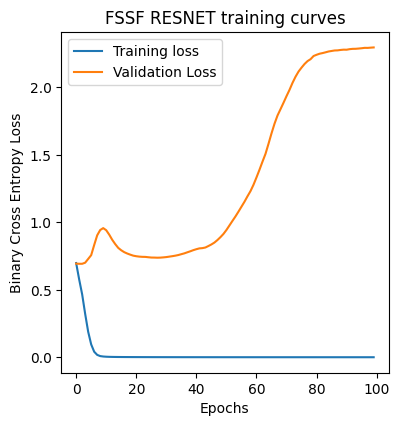

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = pre_processing_temporal(combo_spectral_data, use_resnet=True)
train_loader, val_loader, test_loader = to_dataloader([x_train, x_val, x_test], [y_train, y_val, y_test])
model_resnet = FSSF_RESNET_temporal()
model_resnet.FSSF_RESNET_train(train_loader, val_loader, n_epochs=100,model_path='FSSF_RESNET_model_temporal_ker15_dil13_opad6')

FSSF_RESNET_temporal(
  (upscale): ConvTranspose2d(1, 3, kernel_size=(16, 16), stride=(1, 1), dilation=(14, 14), output_padding=(8, 8))
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, moment

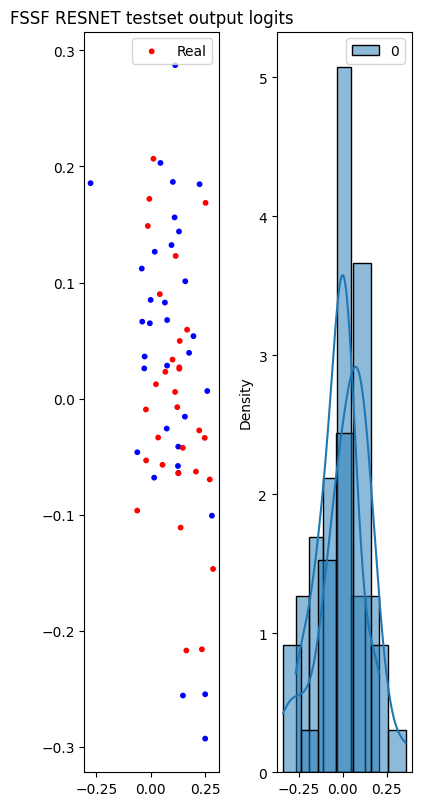

Accuracy: 39.68%
Precision: 38.89%
Recall: 46.67%
F1: 42.42%
AUC: 37.37%


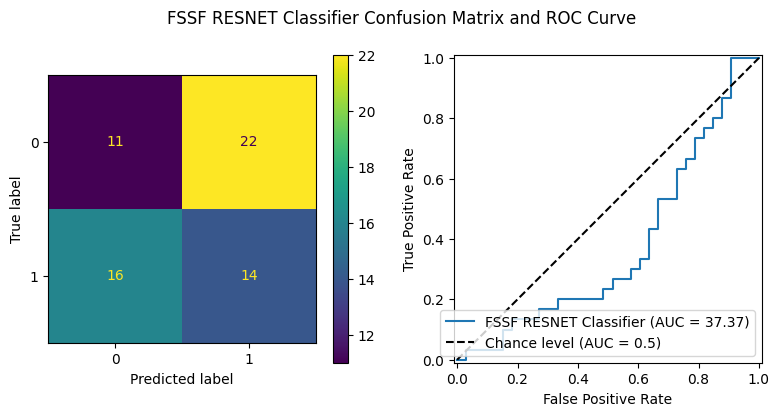

FSSF_RESNET testing complete.


array([[ 0.05345139, -0.05701325],
       [ 0.19520968,  0.05381463],
       [ 0.1626592 , -0.2169805 ],
       [-0.27629295,  0.18554667],
       [ 0.12541166, -0.04135369],
       [-0.06256031, -0.09644862],
       [ 0.28512353, -0.14670385],
       [ 0.07464581,  0.06766248],
       [ 0.11115587,  0.00574557],
       [ 0.0118944 ,  0.20659839],
       [ 0.1660991 ,  0.05935924],
       [ 0.12632059, -0.06404056],
       [ 0.17520647,  0.0394065 ],
       [ 0.2065239 , -0.06287852],
       [ 0.25852552,  0.00653936],
       [ 0.22167012, -0.02738156],
       [ 0.13230403,  0.04966773],
       [ 0.01525517, -0.068066  ],
       [-0.03016342,  0.02599063],
       [ 0.1302941 ,  0.02692914],
       [ 0.24696296, -0.03380353],
       [-0.06207547, -0.04620514],
       [ 0.1088404 ,  0.15607083],
       [ 0.12901253,  0.14396065],
       [ 0.22326155,  0.18466589],
       [ 0.11370427,  0.12287389],
       [ 0.24890026, -0.29284015],
       [-0.02848459,  0.03626431],
       [-0.02176016,

In [ ]:
model_resnet = FSSF_RESNET_temporal()
model_resnet.load_state_dict(torch.load('FSSF_RESNET_model_temporal_ker15_dil13_opad6', weights_only=True))
model_resnet.FSSF_RESNET_test(test_loader)

In [12]:
x_train, x_val, x_test, y_train, y_val, y_test = pre_processing(combo_spectral_data, use_torch=True, tvt=[.2,.2])
train_loader, val_loader, test_loader = to_dataloader([x_train, x_val, x_test], [y_train, y_val, y_test], batch_size=130000)

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=36, out_features=35, bias=True)
    (1): BatchNorm1d(35, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=35, out_features=34, bias=True)
    (5): BatchNorm1d(34, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=34, out_features=33, bias=True)
    (9): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=33, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=32, out_features=31, bias=True)
    (17): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

Epoch:   1%|          | 1/100 [00:00<?, ?it/s]

VAE training started:


Epoch: 101it [02:04,  1.24s/it, training loss=0.702, validation loss=0.701, best validation loss=0.701]

MLP training 100 epochs complete.


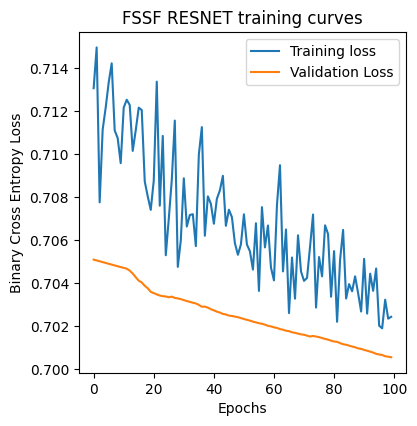

In [19]:
model_mlp = MLP(schedule=list(range(36,1,-1)))
model_mlp.MLP_train(train_loader, val_loader, n_epochs=100,model_path='MLP_frame_based_analysis_36-2')

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=36, out_features=33, bias=True)
    (1): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=33, out_features=30, bias=True)
    (5): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=30, out_features=27, bias=True)
    (9): BatchNorm1d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=27, out_features=24, bias=True)
    (13): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=24, out_features=21, bias=True)
    (17): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

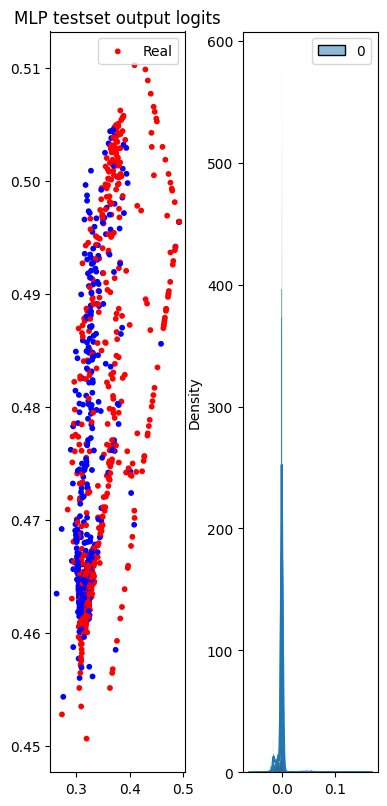

Accuracy: 51.88%
Precision: 51.88%
Recall: 100.0%
F1: 68.31%
AUC: 58.49%


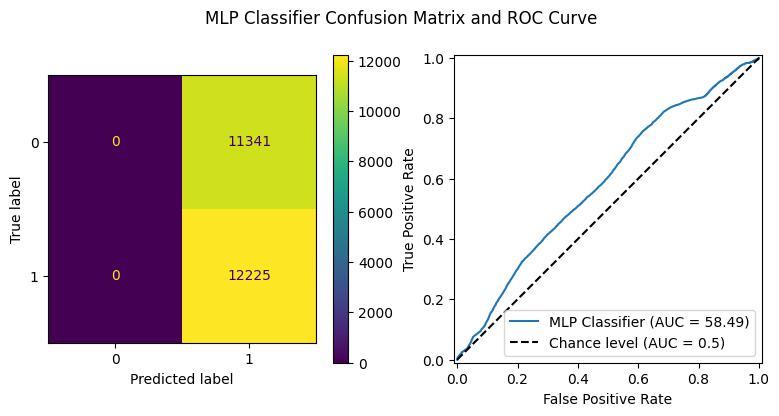

MLP testing complete.


array([[0.3255603 , 0.46661282],
       [0.32690275, 0.46676224],
       [0.32487115, 0.46653366],
       ...,
       [0.3253876 , 0.466593  ],
       [0.32669324, 0.46674296],
       [0.31593865, 0.46307763]], dtype=float32)

In [14]:
model_mlp = MLP()
model_mlp.load_state_dict(torch.load('MLP_frame_based_analysis', weights_only=True))
model_mlp.MLP_test(test_loader)

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=36, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=16, out_features=8, bias=True)
    (9): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=8, out_features=4, bias=True)
    (13): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=4, out_features=2, bias=True)
  )
)
FSSF_RESNET testing started:
Testing Loss: 0.6966970562934875


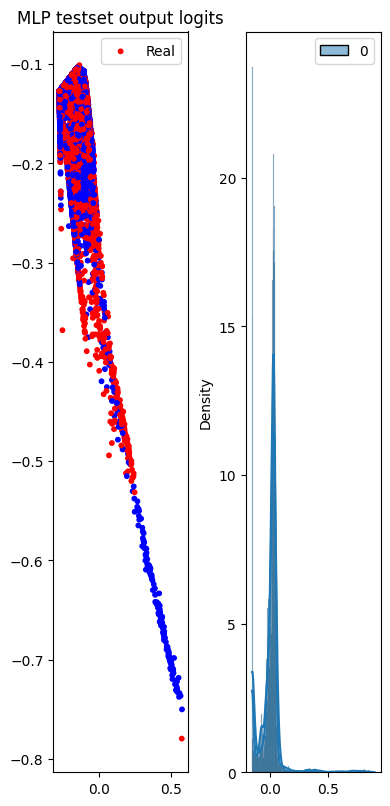

Accuracy: 48.12%
Precision: 0.0%
Recall: 0.0%
F1: 0.0%
AUC: 51.52%


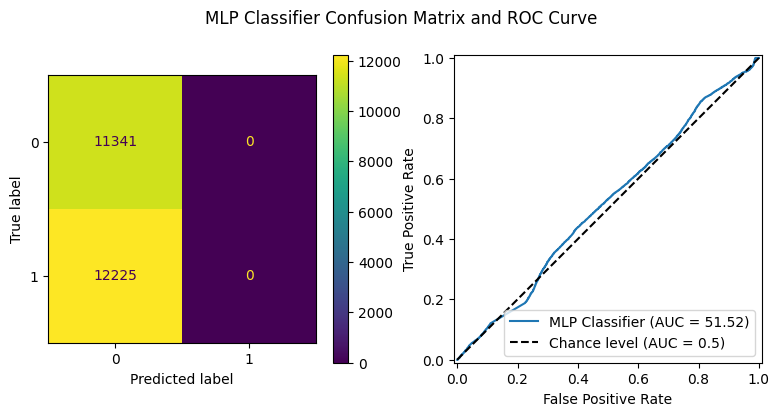

MLP testing complete.


array([[-0.0612824 , -0.16912353],
       [-0.06995401, -0.15815811],
       [-0.09552306, -0.13197081],
       ...,
       [-0.06292666, -0.15963009],
       [-0.07425037, -0.14821725],
       [-0.08071272, -0.14828129]], dtype=float32)

In [17]:
model_mlp = MLP(schedule=(36,32,16,8,4,2))
model_mlp.load_state_dict(torch.load('MLP_frame_based_analysis_36,32,16,8,4,2', weights_only=True))
model_mlp.MLP_test(test_loader)

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=36, out_features=35, bias=True)
    (1): BatchNorm1d(35, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=35, out_features=34, bias=True)
    (5): BatchNorm1d(34, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=34, out_features=33, bias=True)
    (9): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=33, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=32, out_features=31, bias=True)
    (17): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

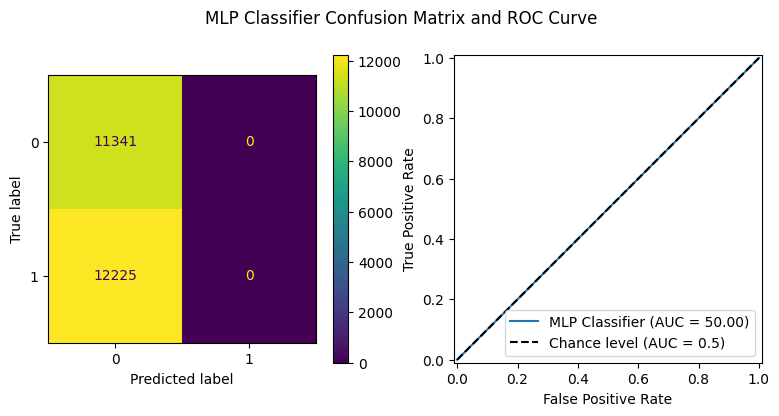

MLP testing complete.


In [24]:
model_mlp = MLP(schedule=list(range(36,1,-1)))
model_mlp.load_state_dict(torch.load('MLP_frame_based_analysis_36-2', weights_only=True))
model_mlp.MLP_test(test_loader)